# Example EEG signals from New York Head model
Demonstration of EEG signal predictions using a complex head model, resulting from single synaptic input onto multicompartment neuron mode set up in LFPy (https://LFPy.readthedocs.io, https://github.com/LFPy/LFPy).

The simulation is broken down in a few steps:

1. Simulate the neuron model and record all transmembrane currents with LFPy
2. Compute the current dipole moment **P** from transmembrane currents using the `lfpykit.CurrentDipoleMoment` class
3. Position the dipole and compute the resulting extracellular potential on the scalp (EEG) from **P** using the `lfpykit.eegmegcalc.NYHeadModel` class

In [20]:
%matplotlib inline

In [24]:
## if running on mybinder or similar, uncomment and run the two following lines to install LFPy. 
## Then restart the kernel.
# !conda install mpi4py -y
!pip install -e git+https://github.com/LFPy/LFPy.git@master#egg=LFPy

Obtaining LFPy from git+https://github.com/LFPy/LFPy.git@master#egg=LFPy
  Cloning https://github.com/LFPy/LFPy.git (to revision master) to /Users/claire/code/test/venv/src/lfpy
  Running command git clone -q https://github.com/LFPy/LFPy.git /Users/claire/code/test/venv/src/lfpy
  Resolved https://github.com/LFPy/LFPy.git to commit 5986b4f5c486b52856ffce2a5928a9bb0968582d
  Attempting uninstall: LFPy
    Found existing installation: LFPy 2.2.1
    Uninstalling LFPy-2.2.1:
      Successfully uninstalled LFPy-2.2.1
  Running setup.py develop for LFPy
You should consider upgrading via the '/Users/claire/code/test/venv/bin/python3.9 -m pip install --upgrade pip' command.


In [43]:
# compile sinsyn.mod file using nrnivmodl script
!nrnivmodl

/usr/bin/xcrun
/Users/claire/code/test/LFPykit/examples
-n Mod files:
-n  "./sinsyn.mod"


COBJS=''
 -> Compiling mod_func.c
/usr/bin/clang -g  -O2   -I.   -I/Applications/NEURON/include  -I/opt/homebrew/Cellar/open-mpi/4.1.0/include -fPIC -c mod_func.c -o mod_func.o
 => LINKING shared library ./libnrnmech.dylib
/usr/bin/clang++ -g  -O2  -std=c++11 -dynamiclib -Wl,-headerpad_max_install_names -undefined dynamic_lookup -fPIC  -I /Applications/NEURON/include -o ./libnrnmech.dylib -Wl,-install_name,@rpath/libnrnmech.dylib \
	  ./mod_func.o ./sinsyn.o  -L/Applications/NEURON/lib -lnrniv -Wl,-rpath,/Applications/NEURON/lib    -lreadline
rm -f ./.libs/libnrnmech.so ; mkdir -p ./.libs ; cp ./libnrnmech.dylib ./.libs/libnrnmech.so
Successfully created arm64/special


In [44]:
import os
import numpy as np
import matplotlib.pyplot as plt
import LFPy
from matplotlib.gridspec import GridSpec
from lfpykit.eegmegcalc import NYHeadModel
import lfpykit
from lfpykit import CellGeometry, CurrentDipoleMoment
from scipy.io import savemat
import neuron

In [50]:
# neuron.h.dt = 0.1   # simulation time resolution (using variable timesteps)
tstop = 500.        # simulation duration
v_init = -65        # membrane voltage(s) at t = 0

#add this? class NeuronCell(lfpykit.CellGeometry, neuron.nrn.Section):
    
    def initialize():
    '''
    initializing function, setting the membrane voltages to v_init and
    resetting all state variables
    '''
    neuron.h.finitialize(v_init)
    cvode.re_init()  # needed with variable time steps?
    neuron.h.frecord_init()


    def apply_transform(M):
    '''Compute P for the current time step
    Parameters:
    M: ndarray
        shape (3, n_seg) linear response matrix
    '''
    I_m = np.array([seg.i_membrane_ for seg in cell])  # membrane current [nA]
    return M @ I_m


    def integrate(calculate_P=True, M=None):
    '''run the simulation up until the simulation duration'''
    if calculate_P:
        P = np.zeros((3, 0))
        while neuron.h.t < tstop:
            P = np.c_[P, apply_transform(M)]
            neuron.h.fadvance()
        return P
    else:
        neuron.run(tstop)
        return

IndentationError: expected an indented block (2635198086.py, line 8)

In [53]:
# variable time step method, use_fast_imem method
cvode = neuron.h.CVode()
cvode.use_fast_imem(1)
cvode.active(1)  # set to zero to use fixed

#Create forward model object and get linear response matrix:

cdm = lfpykit.CurrentDipoleMoment(cell=cell)
M = cdm.get_transformation_matrix()

NameError: name 'cell' is not defined

In [54]:
# calculate current dipole moment
initialize()
P = integrate(calculate_P=True, M=M)

NameError: name 'M' is not defined

In [16]:
#Save data to file
mdic = {"vec": cell.tvec, "somav": cell.somav,"dipole": p, }

savemat("matlab_matrix.mat", mdic)

 We first plot the cell response to the synaptic input

Text(0.5, 0, '$t$ (ms)')

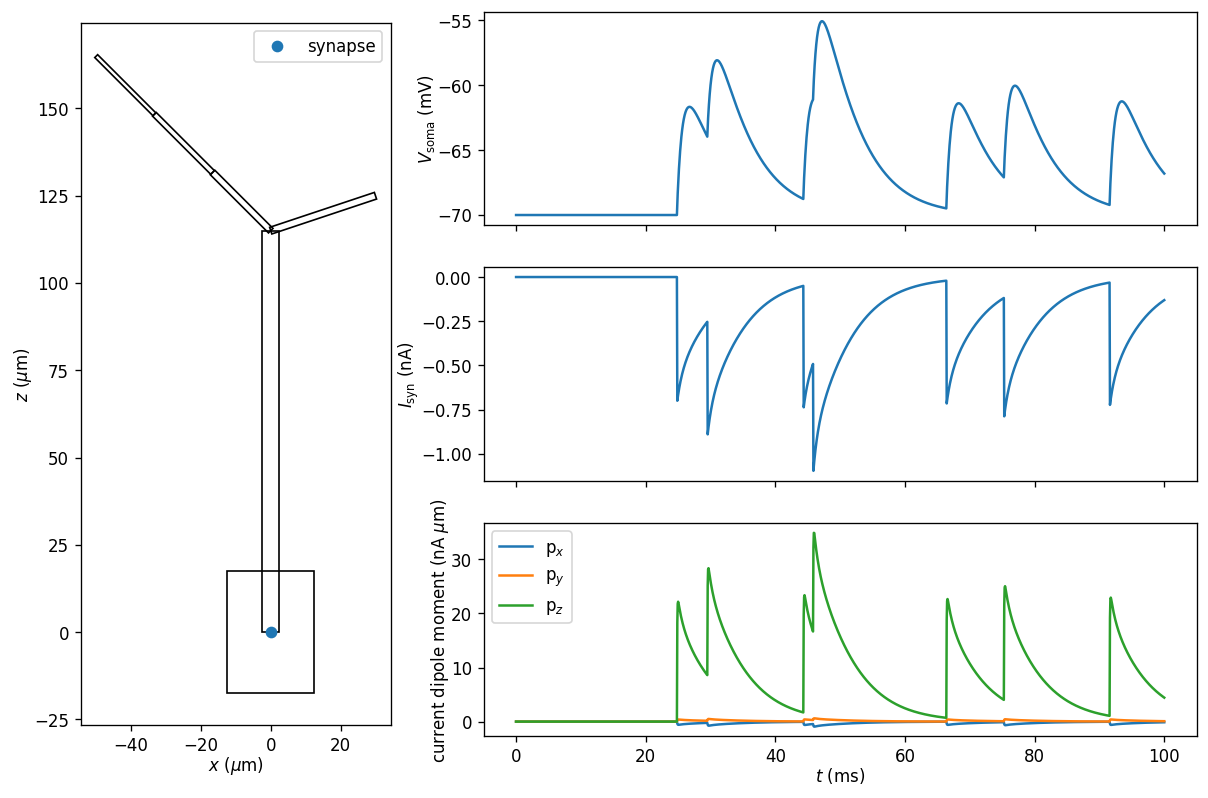

In [5]:
# plot cell 
fig = plt.figure(figsize=(12, 8), dpi=120)
gs = GridSpec(3, 3, wspace=0.3)

# cell setup and sensor locations
ax0 = fig.add_subplot(gs[:, 0], aspect=1)
for xz in cell.get_idx_polygons(projection=('x', 'z')):
    ax0.add_patch(plt.Polygon(np.stack(xz).T, ec='k', fc='none', label='__nolabel__'))
ax0.plot(syn.x, syn.z, 'o', label='synapse')

ax0.legend()
ax0.set_xlabel('$x$ ($\mu$m)', labelpad=0)
ax0.set_ylabel('$z$ ($\mu$m)', labelpad=0)

# somatic voltage
ax1 = fig.add_subplot(gs[0, 1:])
ax1.plot(cell.tvec, cell.somav)
ax1.set_ylabel(r'$V_\mathrm{soma}$ (mV)', labelpad=0)
ax1.set_xticklabels([])

# synapse current
ax2 = fig.add_subplot(gs[1, 1:])
ax2.plot(cell.tvec, syn.i)
ax2.set_ylabel(r'$I_\mathrm{syn}$ (nA)', labelpad=0)
ax2.set_xticklabels([])

# current dipole moment
ax3 = fig.add_subplot(gs[2, 1:])
[ax3.plot(cell.tvec, p[idx], label=["p$_x$", "p$_y$", "p$_z$"][idx]) for idx in range(p.shape[0])]
ax3.set_ylabel(r'current dipole moment (nA $\mu$m)', labelpad=0)
ax3.legend()
ax3.set_xlabel('$t$ (ms)', labelpad=0)

We now initiate the New York Head model

In [6]:
nyhead = NYHeadModel()

dipole_location = 'motorsensory_cortex'  # predefined location from NYHead class
nyhead.set_dipole_pos(dipole_location)
M = nyhead.get_transformation_matrix()

# We rotate current dipole moment to be oriented along the normal vector of cortex
p = nyhead.rotate_dipole_to_surface_normal(P)
eeg = M @ p * 1E9 # [mV] -> [pV] unit conversion

New York head model not found: /Users/claire/code/test/venv/lib/python3.9/site-packages/lfpykit/sa_nyhead.mat


Should it be downloaded (710 MB)? [y/n]:  y


Now downloading. This might take a while ...
Download done!


Closest electrode to dipole: 20.02 mm


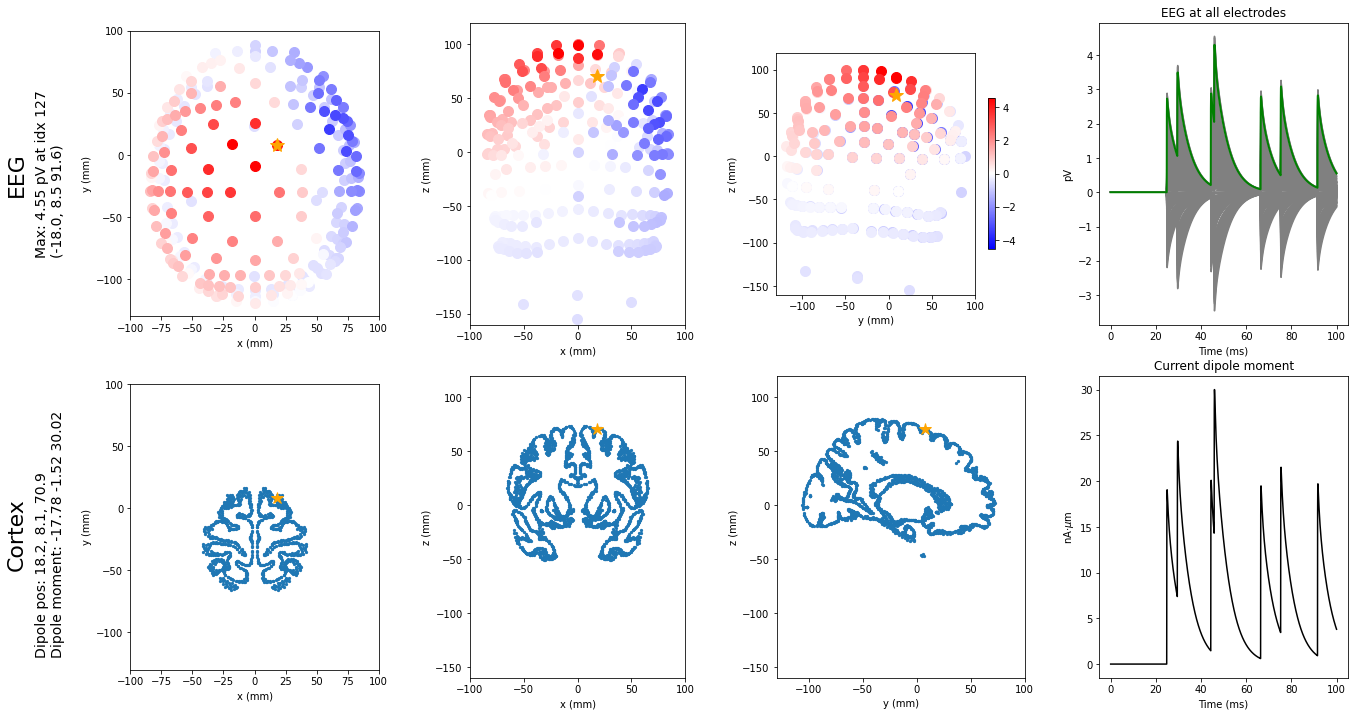

In [7]:
x_lim = [-100, 100]
y_lim = [-130, 100]
z_lim = [-160, 120]

t = cell.tvec

plt.close("all")
fig = plt.figure(figsize=[19, 10])
fig.subplots_adjust(top=0.96, bottom=0.05, hspace=0.17, wspace=0.3, left=0.1, right=0.99)
ax1 = fig.add_subplot(245, aspect=1, xlabel="x (mm)", ylabel='y (mm)', xlim=x_lim, ylim=y_lim)
ax2 = fig.add_subplot(246, aspect=1, xlabel="x (mm)", ylabel='z (mm)', xlim=x_lim, ylim=z_lim)
ax3 = fig.add_subplot(247, aspect=1, xlabel="y (mm)", ylabel='z (mm)', xlim=y_lim, ylim=z_lim)
ax_eeg = fig.add_subplot(244, xlabel="Time (ms)", ylabel='pV', title='EEG at all electrodes')

ax_cdm = fig.add_subplot(248, xlabel="Time (ms)", ylabel='nA$\cdot \mu$m', 
                         title='Current dipole moment')
dist, closest_elec_idx = nyhead.find_closest_electrode()
print("Closest electrode to dipole: {:1.2f} mm".format(dist))

max_elec_idx = np.argmax(np.std(eeg, axis=1))
time_idx = np.argmax(np.abs(eeg[max_elec_idx]))
max_eeg = np.max(np.abs(eeg[:, time_idx]))
max_eeg_idx = np.argmax(np.abs(eeg[:, time_idx]))

max_eeg_pos = nyhead.elecs[:3, max_eeg_idx]
fig.text(0.01, 0.25, "Cortex", va='center', rotation=90, fontsize=22)
fig.text(0.03, 0.25, 
         "Dipole pos: {:1.1f}, {:1.1f}, {:1.1f}\nDipole moment: {:1.2f} {:1.2f} {:1.2f}".format(
    nyhead.dipole_pos[0], nyhead.dipole_pos[1], nyhead.dipole_pos[2],
    p[0, time_idx], p[1, time_idx], p[2, time_idx]
), va='center', rotation=90, fontsize=14)

fig.text(0.01, 0.75, "EEG", va='center', rotation=90, fontsize=22)
fig.text(0.03, 0.75, "Max: {:1.2f} pV at idx {}\n({:1.1f}, {:1.1f} {:1.1f})".format(
         max_eeg, max_eeg_idx, max_eeg_pos[0], max_eeg_pos[1], max_eeg_pos[2]), va='center',
         rotation=90, fontsize=14)

ax7 = fig.add_subplot(241, aspect=1, xlabel="x (mm)", ylabel='y (mm)',
                      xlim=x_lim, ylim=y_lim)
ax8 = fig.add_subplot(242, aspect=1, xlabel="x (mm)", ylabel='z (mm)',
                      xlim=x_lim, ylim=z_lim)
ax9 = fig.add_subplot(243, aspect=1, xlabel="y (mm)", ylabel='z (mm)',
                      xlim=y_lim, ylim=z_lim)

ax_cdm.plot(t, p[2, :], 'k')
[ax_eeg.plot(t, eeg[idx, :], c='gray') for idx in range(eeg.shape[0])]
ax_eeg.plot(t, eeg[closest_elec_idx, :], c='green', lw=2)

vmax = np.max(np.abs(eeg[:, time_idx]))
v_range = vmax
cmap = lambda v: plt.cm.bwr((v + vmax) / (2*vmax))

threshold = 2

xz_plane_idxs = np.where(np.abs(nyhead.cortex[1, :] - nyhead.dipole_pos[1]) < threshold)[0]
xy_plane_idxs = np.where(np.abs(nyhead.cortex[2, :] - nyhead.dipole_pos[2]) < threshold)[0]
yz_plane_idxs = np.where(np.abs(nyhead.cortex[0, :] - nyhead.dipole_pos[0]) < threshold)[0]

ax1.scatter(nyhead.cortex[0, xy_plane_idxs], nyhead.cortex[1, xy_plane_idxs], s=5)
ax2.scatter(nyhead.cortex[0, xz_plane_idxs], nyhead.cortex[2, xz_plane_idxs], s=5)
ax3.scatter(nyhead.cortex[1, yz_plane_idxs], nyhead.cortex[2, yz_plane_idxs], s=5)

for idx in range(eeg.shape[0]):
    c = cmap(eeg[idx, time_idx])
    ax7.plot(nyhead.elecs[0, idx], nyhead.elecs[1, idx], 'o', ms=10, c=c, 
             zorder=nyhead.elecs[2, idx])
    ax8.plot(nyhead.elecs[0, idx], nyhead.elecs[2, idx], 'o', ms=10, c=c, 
             zorder=nyhead.elecs[1, idx])
    ax9.plot(nyhead.elecs[1, idx], nyhead.elecs[2, idx], 'o', ms=10, c=c, 
             zorder=-nyhead.elecs[0, idx])

img = ax3.imshow([[], []], origin="lower", vmin=-vmax,
                 vmax=vmax, cmap=plt.cm.bwr)
plt.colorbar(img, ax=ax9, shrink=0.5)

ax1.plot(nyhead.dipole_pos[0], nyhead.dipole_pos[1], '*', ms=12, color='orange', zorder=1000)
ax2.plot(nyhead.dipole_pos[0], nyhead.dipole_pos[2], '*', ms=12, color='orange', zorder=1000)
ax3.plot(nyhead.dipole_pos[1], nyhead.dipole_pos[2], '*', ms=12, color='orange', zorder=1000)

ax7.plot(nyhead.dipole_pos[0], nyhead.dipole_pos[1], '*', ms=15, color='orange', zorder=1000)
ax8.plot(nyhead.dipole_pos[0], nyhead.dipole_pos[2], '*', ms=15, color='orange', zorder=1000)
ax9.plot(nyhead.dipole_pos[1], nyhead.dipole_pos[2], '*', ms=15, color='orange', zorder=1000)

In [8]:
scipy.io.savemat